# Analysis of Washington Post headlines during the COVID-19 pandemic

The Washington Post is the #7 newspaper in the U.S. by circulation. https://en.wikipedia.org/wiki/List_of_newspapers_in_the_United_States#Top_10_newspapers_by_circulation

Digital circulation is more difficult to gauge. The Washington Post is one of the newspapers that have not fully reported their digital circulation to the Alliance for Audited Media (AAM), the group that audits the circulation figures of many of the largest North American newspapers and other publications. https://www.journalism.org/fact-sheet/newspapers/

Nevertheless the Washington Post is a top newspaper in the United States. 

This notebook analyzes how the headlines have evolved since the day the first case appeared in the U.S.

Import libraries.

In [657]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import StaleElementReferenceException, NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC
import datetime
import pandas as pd
import time
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy
import gensim
from sklearn.manifold import TSNE
from datetime import timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from timeit import default_timer as timer
import re
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
%matplotlib notebook

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed
[nltk_data]     (_ssl.c:833)>


## Scrape headlines from the Washington Post

Set date range we are interested in. WHO knew about coronavirus as early as December 8, 2019 (https://en.wikipedia.org/wiki/Coronavirus_disease_2019), so our start date is December 8.

In [518]:
start = datetime.date(2019, 12, 8)
end = datetime.date.today()
num_days = (end - start).days
date_range = pd.date_range(start, periods=num_days).tolist()

In [519]:
print('Range: ' + str(start) + ' to ' + str(end))
print('Length: ' + str(num_days) + ' days')
date_range[:10]

Range: 2019-12-08 to 2020-04-12
Days: 126


[Timestamp('2019-12-08 00:00:00', freq='D'),
 Timestamp('2019-12-09 00:00:00', freq='D'),
 Timestamp('2019-12-10 00:00:00', freq='D'),
 Timestamp('2019-12-11 00:00:00', freq='D'),
 Timestamp('2019-12-12 00:00:00', freq='D'),
 Timestamp('2019-12-13 00:00:00', freq='D'),
 Timestamp('2019-12-14 00:00:00', freq='D'),
 Timestamp('2019-12-15 00:00:00', freq='D'),
 Timestamp('2019-12-16 00:00:00', freq='D'),
 Timestamp('2019-12-17 00:00:00', freq='D')]

Set Washington Post URLs from the Internet Archive Wayback Machine for 2019 and 2020.

In [ ]:
urls = ['https://web.archive.org/web/20190901000000*/washingtonpost.com', 
        'https://web.archive.org/web/*/washingtonpost.com']

For each day in our range, collect headlines from the last snapshot of that day.

In [528]:
browser = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') 
browser.maximize_window() 
data = {}

for j in range(0, len(urls)):
    
    # Navigate browser to URL
    browser.get(urls[j])
    
    # Get all date elements on the page
    calendar_grid = WebDriverWait(browser, 20).until(EC.element_to_be_clickable((By.CLASS_NAME, 'calendar-grid')))
    dates = calendar_grid.find_elements_by_tag_name('a')  
    
    if j == 0: # If 2019, we will iterate over dates backward from last one (Dec 31)
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
        time.sleep(5)
        start = len(dates) - 1
        end = 0
        step = -1
    elif j == 1: # If 2020, we will iterate over dates forward from first one (Jan 1)
        start = 0
        end = len(dates) 
        step = 1
    
    # Iterate over dates 
    for i in range(start, end, step):        
        # Hover over the date, let popup appear, wait for loader to disappear, select scroll area
        browser.execute_script("""
            arguments[0].addEventListener('mouseover', function() {
            });
            
            var event = new MouseEvent('mouseover', {
                'view': window,
                'bubbles': true,
                'cancelable': true
            });
            
            arguments[0].dispatchEvent(event);""", dates[i])
        popup = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content')))
        WebDriverWait(browser, 20).until(EC.invisibility_of_element_located((By.TAG_NAME, 'svg')))
        scroll_area = WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.CSS_SELECTOR, '.popup-of-day-content > ul > div')))

        # Get date text and check that it is in our range
        date = popup.find_element_by_class_name('day-tooltip-title')
        date_formatted = datetime.datetime.strptime(date.text, '%B %d, %Y')
        print('Date: ' + str(date_formatted))
        if date_formatted not in date_range:
            break # skip if it is not
        else:
            attempts = 0
            while attempts < 5:
                try:
                    browser.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scroll_area)
                    snapshots = popup.find_elements_by_tag_name('a')        
                    last_snapshot = snapshots[len(snapshots) - 1]
                    print('Last snapshot taken at ' + last_snapshot.text)
                    data[date_formatted] = {'link': last_snapshot.get_attribute('href'),
                                            'time': last_snapshot.text,
                                            'headlines': [],
                                            'sections': []}
                    break
                except StaleElementReferenceException:
                    attempts += 1

Date: 2019-12-31 00:00:00
Last snapshot taken at 23:58:31
Date: 2019-12-30 00:00:00
Last snapshot taken at 23:46:44
Date: 2019-12-29 00:00:00
Last snapshot taken at 23:21:32
Date: 2019-12-28 00:00:00
Last snapshot taken at 23:33:54
Date: 2019-12-27 00:00:00
Last snapshot taken at 23:59:13
Date: 2019-12-26 00:00:00
Last snapshot taken at 23:40:41
Date: 2019-12-25 00:00:00
Last snapshot taken at 23:53:47
Date: 2019-12-24 00:00:00
Last snapshot taken at 23:46:18
Date: 2019-12-23 00:00:00
Last snapshot taken at 23:20:02
Date: 2019-12-22 00:00:00
Last snapshot taken at 23:05:35
Date: 2019-12-21 00:00:00
Last snapshot taken at 23:59:58
Date: 2019-12-20 00:00:00
Last snapshot taken at 23:31:57
Date: 2019-12-19 00:00:00
Last snapshot taken at 23:36:53
Date: 2019-12-18 00:00:00
Last snapshot taken at 23:58:13
Date: 2019-12-17 00:00:00
Last snapshot taken at 23:31:30
Date: 2019-12-16 00:00:00
Last snapshot taken at 23:51:45
Date: 2019-12-15 00:00:00
Last snapshot taken at 23:02:46
Date: 2019-12-

View our data so far.

In [573]:
data

{datetime.datetime(2019, 12, 31, 0, 0): {'link': 'https://web.archive.org/web/20191231235831/washingtonpost.com',
  'time': '23:58:31',
  'headlines': ['Listen to Post Reports',
   'How black women are fighting for — and winning — space on the bookshelf',
   'On Tonight’s Podcast',
   'Listen to Post Reports',
   'Militia supporters chanting ‘Death to America’ break into U.S. Embassy compound in Baghdad',
   'Retropolis: ‘Death to America’ chants heard in Baghdad echo the Iran hostage crisis',
   'Trump threatens Iran after embassy attack, but is reluctant to get more involved in region',
   'Why Iraq is at the center of the dispute between Iran and the United States',
   'Trump Organization fires more undocumented workers, a year after its use of illegal labor was revealed',
   'EPA advisory board, dominated by Trump appointees, warns regulatory rollbacks clash with established science',
   'The calendar says we’re moving on from the 2010s. It sure doesn’t feel that way.',
   'More go

Scrape headlines from each day link.

In [766]:
def get_section(element):
    try:
        return re.search('washingtonpost.com/([\w-]*)/', element.get_attribute('href'))[1]
    except NoSuchElementException:
        #print('Not a link')
        return None
    except TypeError:
        #print('Not a WashingtonPost link')
        return None
    else: 
        #print('Empty headline or "More Editors\' Picks"')
        return None

browser = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver') # brew install chromedriver then see in terminal where it was installed to and paste this
data[datetime.datetime(2019, 12, 10, 0, 0)]['link'] = 'https://web.archive.org/web/20191210232000/https://www.washingtonpost.com/'
data[datetime.datetime(2020, 3, 9, 0, 0)]['link'] = 'https://web.archive.org/web/20200309230659/https://www.washingtonpost.com/'
data[datetime.datetime(2020, 2, 5, 0, 0)]['link'] = 'https://web.archive.org/web/20200205224814/https://www.washingtonpost.com/'

unacceptable_headlines = ['', 
                          'More Editors’ Picks',
                          'Listen to Post Reports',
                          'On Tonight’s Podcast',
                          'Here are 15 of the week’s best photos']

for day in data:
    if len(data[day]['headlines']) == 0:
        print('Scraping ' + str(day) + '...')
        headlines = []
        sections = []
        browser.get(data[day]['link'])
        elements = browser.find_elements_by_xpath('//a[@data-pb-field=\'headlines.basic\']')

        for element in elements:
            headline = element.text.strip()
            if headline not in unacceptable_headlines:
                section = get_section(element)
                if section: # if section was found, note section & headline
                    sections.append(section)
                    headlines.append(headline)

        data[day]['sections'] = sections
        data[day]['headlines'] = headlines

        print('Found ' + str(len(headlines)) + ' headlines')
        print('Found ' + str(len(sections)) + ' sections')

        time.sleep(5)

Scraping 2020-02-05 00:00:00...
Found 79 headlines
Found 79 sections


Save to CSV.

In [767]:
df = pd.DataFrame.from_dict(data).T.rename_axis('date').reset_index()
df.to_csv('data.csv', index=False)
df

,date,link,time,headlines,sections
0,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"[Listen to Post Reports, How black women are f...","[podcasts, podcasts, podcasts, podcasts, world..."
1,2019-12-30,https://web.archive.org/web/20191230234644/was...,23:46:44,"[Listen to Post Reports, A tale of two billion...","[podcasts, podcasts, podcasts, podcasts, busin..."
2,2019-12-29,https://web.archive.org/web/20191229232132/was...,23:21:32,[Giuliani took part in 2018 call with Maduro a...,"[politics, powerpost, nation, nation, entertai..."
3,2019-12-28,https://web.archive.org/web/20191228233354/was...,23:33:54,"[Drug regulators, lawmakers spar over whether ...","[investigations, politics, politics, business,..."
4,2019-12-27,https://web.archive.org/web/20191227235913/was...,23:59:13,"[Listen to Post Reports, The Altamont Concert,...","[podcasts, podcasts, podcasts, podcasts, busin..."
...,...,...,...,...,...
121,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,[Trump removes inspector general who was to ov...,"[national-security, us-policy, national-securi..."
122,2020-04-08,https://web.archive.org/web/20200408222337/was...,22:23:37,"[Sanders ends White House bid, clears way for ...","[politics, health, local, business, us-policy,..."
123,2020-04-09,https://web.archive.org/web/20200409224804/was...,22:48:04,[Wide swaths of the country are ill-prepared f...,"[graphics, business, national, politics, natio..."
124,2020-04-10,https://web.archive.org/web/20200410094925/was...,09:49:25,[Trump seeks to reopen much of U.S. next month...,"[national, world, national-security, health, h..."


## Load the data

In [768]:
df = pd.read_csv('data.csv', index_col=False, parse_dates=['date'])
df['headlines'] = df['headlines'].apply(literal_eval)
df['sections'] = df['sections'].apply(literal_eval)
df

,date,link,time,headlines,sections
0,2019-12-31,https://web.archive.org/web/20191231235831/was...,23:58:31,"[Listen to Post Reports, How black women are f...","[podcasts, podcasts, podcasts, podcasts, world..."
1,2019-12-30,https://web.archive.org/web/20191230234644/was...,23:46:44,"[Listen to Post Reports, A tale of two billion...","[podcasts, podcasts, podcasts, podcasts, busin..."
2,2019-12-29,https://web.archive.org/web/20191229232132/was...,23:21:32,[Giuliani took part in 2018 call with Maduro a...,"[politics, powerpost, nation, nation, entertai..."
3,2019-12-28,https://web.archive.org/web/20191228233354/was...,23:33:54,"[Drug regulators, lawmakers spar over whether ...","[investigations, politics, politics, business,..."
4,2019-12-27,https://web.archive.org/web/20191227235913/was...,23:59:13,"[Listen to Post Reports, The Altamont Concert,...","[podcasts, podcasts, podcasts, podcasts, busin..."
...,...,...,...,...,...
121,2020-04-07,https://web.archive.org/web/20200407223927/was...,22:39:27,[Trump removes inspector general who was to ov...,"[national-security, us-policy, national-securi..."
122,2020-04-08,https://web.archive.org/web/20200408222337/was...,22:23:37,"[Sanders ends White House bid, clears way for ...","[politics, health, local, business, us-policy,..."
123,2020-04-09,https://web.archive.org/web/20200409224804/was...,22:48:04,[Wide swaths of the country are ill-prepared f...,"[graphics, business, national, politics, natio..."
124,2020-04-10,https://web.archive.org/web/20200410094925/was...,09:49:25,[Trump seeks to reopen much of U.S. next month...,"[national, world, national-security, health, h..."


## Explore headlines

Collect all headlines and sections into two arrays.

In [769]:
all_headlines = np.concatenate(df['headlines'].values)
print('Headlines: ' + str(len(all_headlines)))
all_headlines

Headlines: 10159


array(['Listen to Post Reports',
       'How black women are fighting for — and winning — space on the bookshelf',
       'On Tonight’s Podcast', ...,
       'Darran Simon, Washington Post journalist, dies at 43',
       'Mort Drucker, Mad magazine artist who drew humor from American life, dies at 91',
       'Linda Tripp, whose taped calls with Monica Lewinsky led to Clinton impeachment, dies at 70'],
      dtype='<U168')

In [770]:
all_sections = np.concatenate(df['sections'].values)
print('Sections: ' + str(len(all_sections)))
all_sections

Sections: 10159


array(['podcasts', 'podcasts', 'podcasts', ..., 'local', 'local', 'local'],
      dtype='<U19')

Delete any headlines and sections that are not really headlines. I updated the code above to account for this before they are saved. Can delete this if we rerun the above code for extracting headlines and sections and it works.

In [771]:
indices_to_del = []

for i, headline in enumerate(all_headlines):
    if headline in unacceptable_headlines:
        indices_to_del.append(i)
        
print('Deleting ' + str(len(indices_to_del)) + ' headlines and sections')
all_headlines = [x for i, x in enumerate(all_headlines) if i not in indices_to_del]
all_sections = [x for i, x in enumerate(all_sections) if i not in indices_to_del]
print('Headlines: ' + str(len(all_headlines)))
print('Sections: ' + str(len(all_sections)))

Deleting 220 headlines and sections
Headlines: 9939
Sections: 9939


Top 10 most commonly appearing headlines:

In [772]:
pd.Series(all_headlines).value_counts().head(10)

Guide to the pandemic                                                29
Lives adrift in a rapidly warming world: A photographic portrait     22
Art With a Point: Illustrations from the Post Magazine               21
Mapping the spread of the new coronavirus                            20
How epidemics like covid-19 end (and how to end them faster)         18
Mapping the spread of the coronavirus in the U.S. and worldwide      16
Scenes from Australia’s deadly bush fire crisis                      15
The new sick leave law doesn’t help the workers that need it most    13
Trump ramps up border-wall construction ahead of 2020 vote           12
What you need to know about coronavirus                              11
dtype: int64

How many times does coronavirus appear in the headlines, per day?

In [924]:
appearances = []
headline_appearances = []
for day in df.iterrows():
    h = []
    appears = 0
    headlines = day[1]['headlines']
    num_headlines = len(headlines)
    for headline in headlines:
        if 'coronavirus' in headline.lower() or 'covid-19' in headline.lower() or 'covid19' in headline.lower() or 'pandemic' in headline.lower() or 'outbreak' in headline.lower():
            appears += 1
            h.append(headline)
    appearances.append((appears/num_headlines) * 100) # percentage
    headline_appearances.append(h)
    
appearances

[0.0,
 0.0,
 0.0,
 0.0,
 1.2195121951219512,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3333333333333335,
 0.0,
 1.2345679012345678,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.5,
 0.0,
 1.3333333333333335,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.5,
 6.25,
 6.329113924050633,
 7.228915662650602,
 8.860759493670885,
 10.38961038961039,
 7.792207792207792,
 5.128205128205128,
 7.59493670886076,
 7.317073170731707,
 12.345679012345679,
 7.4074074074074066,
 9.090909090909092,
 5.333333333333334,
 7.5,
 6.329113924050633,
 6.25,
 4.819277108433735,
 5.194805194805195,
 2.5974025974025974,
 3.6585365853658534,
 5.0,
 6.25,
 5.063291139240507,
 3.79746835443038,
 3.8461538461538463,
 6.578947368421052,
 5.128205128205128,
 7.4074074074074066,
 8.641975308641975,
 7.4074074074074066,
 8.536585365853659,
 9.333333333333334,
 6.578947368421052,
 8.75,
 16.666666666666664,
 14.666666666666666,
 18.75,
 24.09638554216

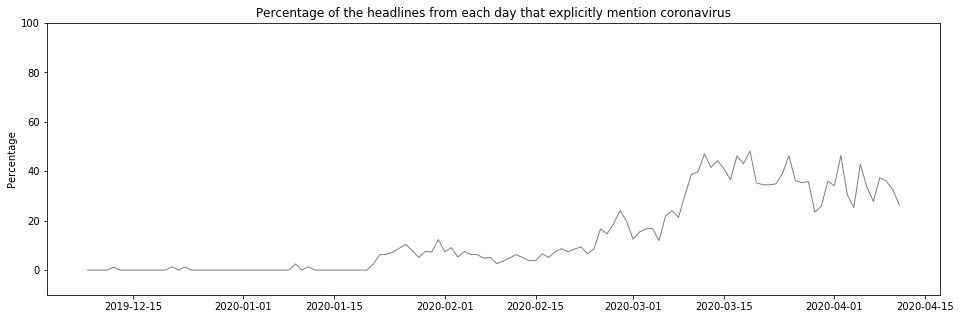

In [806]:
plt.figure(figsize=(16, 5))
plt.ylim(-10, 100)
plt.ylabel('Percentage')
plt.title('Percentage of the headlines from each day that explicitly mention coronavirus')
plt.plot(date_range, appearances, color='gray', lw=1)

Group by unique headlines, since some headlines are the same on multiple days, and we want unique headlines for some purposes. 

In [816]:
df_headsects = pd.DataFrame({'headline': all_headlines, 'section': all_sections})
df_headsects

,headline,section
0,How black women are fighting for — and winning...,podcasts
1,Militia supporters chanting ‘Death to America’...,world
2,Retropolis: ‘Death to America’ chants heard in...,history
3,"Trump threatens Iran after embassy attack, but...",politics
4,Why Iraq is at the center of the dispute betwe...,world
...,...,...
9934,Undocumented workers among those hit first — a...,business
9935,"Pat Stapleton, all-star defenseman for Chicago...",local
9936,"Darran Simon, Washington Post journalist, dies...",local
9937,"Mort Drucker, Mad magazine artist who drew hum...",local


In [817]:
df_headsects.drop_duplicates(subset='headline', inplace=True, keep='first')
df_headsects

,headline,section
0,How black women are fighting for — and winning...,podcasts
1,Militia supporters chanting ‘Death to America’...,world
2,Retropolis: ‘Death to America’ chants heard in...,history
3,"Trump threatens Iran after embassy attack, but...",politics
4,Why Iraq is at the center of the dispute betwe...,world
...,...,...
9933,‘Screen time’ has gone from sin to survival tool,technology
9934,Undocumented workers among those hit first — a...,business
9935,"Pat Stapleton, all-star defenseman for Chicago...",local
9936,"Darran Simon, Washington Post journalist, dies...",local


## Word distributions

**Headline word length**.

First import stopwords. We don't want to consider words such as "the," "an," etc. 

In [818]:
stop_words = set(stopwords.words('english'))

In [819]:
headline_lengths = [len(x.split(' ')) for x in df_headsects['headline']]
headline_lengths

[14,
 13,
 13,
 15,
 15,
 16,
 14,
 15,
 7,
 8,
 11,
 10,
 9,
 11,
 9,
 13,
 12,
 10,
 13,
 10,
 15,
 8,
 9,
 12,
 16,
 6,
 6,
 15,
 14,
 14,
 5,
 11,
 5,
 15,
 8,
 11,
 15,
 11,
 17,
 14,
 13,
 14,
 15,
 14,
 18,
 15,
 13,
 14,
 12,
 11,
 8,
 13,
 9,
 13,
 9,
 6,
 14,
 11,
 12,
 13,
 11,
 10,
 7,
 9,
 9,
 11,
 7,
 13,
 13,
 14,
 13,
 14,
 14,
 19,
 9,
 8,
 12,
 12,
 11,
 13,
 12,
 10,
 10,
 11,
 12,
 13,
 12,
 15,
 12,
 6,
 15,
 12,
 8,
 16,
 14,
 17,
 19,
 10,
 18,
 13,
 16,
 13,
 17,
 15,
 12,
 7,
 11,
 11,
 11,
 5,
 13,
 14,
 13,
 25,
 8,
 8,
 5,
 7,
 7,
 11,
 14,
 9,
 11,
 14,
 14,
 16,
 12,
 14,
 10,
 12,
 12,
 12,
 10,
 11,
 11,
 20,
 14,
 5,
 15,
 12,
 10,
 18,
 15,
 13,
 8,
 15,
 12,
 9,
 7,
 10,
 13,
 4,
 11,
 14,
 13,
 11,
 6,
 15,
 17,
 6,
 13,
 11,
 13,
 11,
 9,
 8,
 8,
 10,
 12,
 10,
 11,
 16,
 14,
 11,
 16,
 19,
 6,
 15,
 15,
 12,
 20,
 10,
 14,
 5,
 9,
 5,
 12,
 10,
 14,
 11,
 12,
 17,
 10,
 16,
 15,
 14,
 14,
 9,
 13,
 12,
 9,
 19,
 13,
 11,
 17,
 16,
 12,
 16,
 12,
 1

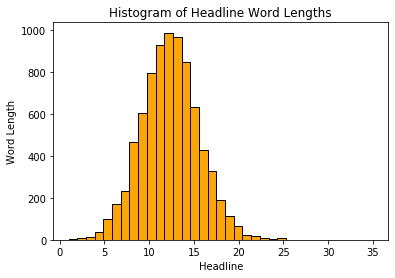

In [833]:
%matplotlib inline
plt.hist(headline_lengths, color='orange', edgecolor='black', bins=35)
plt.title('Histogram of Headline Word Lengths')
plt.xlabel('Headline')
plt.ylabel('Word Length')
plt.show()

Most headlines are 12 words in length. 

In [825]:
scipy.mode(headline_lengths).mode[0]

12

Most frequently used words overall.

In [826]:
words = ' '.join([re.sub(r'[,?:.-]', '', headline) for headline in df_headsects['headline']]).split(' ')
words = [word.lower() for word in words if word.lower() not in stop_words and word.strip() != '' and word != '—']
print('Words: ' + str(len(words)))
words

Words: 66302


['black',
 'women',
 'fighting',
 'winning',
 'space',
 'bookshelf',
 'militia',
 'supporters',
 'chanting',
 '‘death',
 'america’',
 'break',
 'us',
 'embassy',
 'compound',
 'baghdad',
 'retropolis',
 '‘death',
 'america’',
 'chants',
 'heard',
 'baghdad',
 'echo',
 'iran',
 'hostage',
 'crisis',
 'trump',
 'threatens',
 'iran',
 'embassy',
 'attack',
 'reluctant',
 'get',
 'involved',
 'region',
 'iraq',
 'center',
 'dispute',
 'iran',
 'united',
 'states',
 'trump',
 'organization',
 'fires',
 'undocumented',
 'workers',
 'year',
 'use',
 'illegal',
 'labor',
 'revealed',
 'epa',
 'advisory',
 'board',
 'dominated',
 'trump',
 'appointees',
 'warns',
 'regulatory',
 'rollbacks',
 'clash',
 'established',
 'science',
 'calendar',
 'says',
 'we’re',
 'moving',
 '2010s',
 'sure',
 'doesn’t',
 'feel',
 'way',
 'good',
 'news',
 'happened',
 '2019',
 'iran',
 'outplayed',
 'united',
 'states',
 'dwyane',
 'wade',
 'gabrielle',
 'union’s',
 'simple',
 'openarmed',
 'act',
 'parental',
 '

In [827]:
pd.Series(words).value_counts()[:25]

coronavirus    904
trump          680
us             484
new            435
dies           291
trump’s        281
says           248
one            186
say            173
house          172
could          156
democrats      152
dc             150
it’s           149
impeachment    140
first          125
pandemic       123
carolyn        122
hax            121
police         119
may            119
people         118
make           117
help           115
time           115
dtype: int64

Most frequently used words, monthly.

## Explore sections

Top 10 most populous sections, overall.

In [872]:
top_10_sects = df_headsects['section'].value_counts().head(10)
top_10_sects

politics         852
local            805
world            711
opinions         708
sports           587
business         541
lifestyle        527
outlook          413
health           317
entertainment    301
Name: section, dtype: int64

Did the number of articles change over time in each section? Probably not because there are fixed section cards and they want to vary the sections. 

Change this to percentage of headlines that day?

Only health section sees a significant increase.

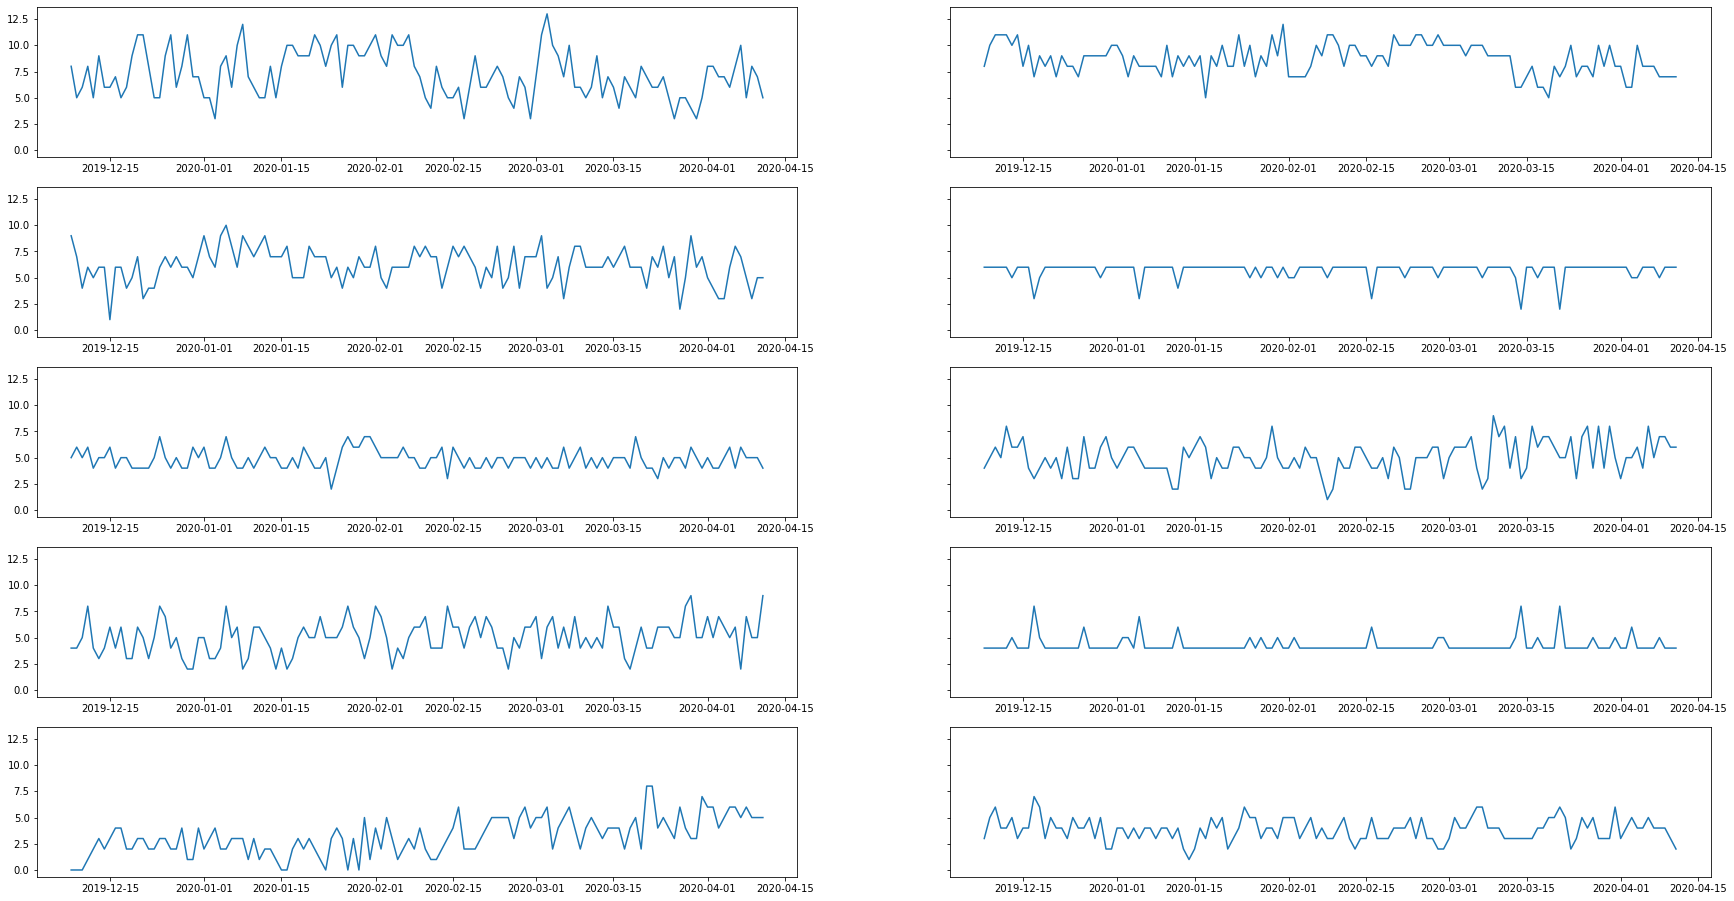

In [871]:
politics = [pd.Series(x).value_counts()['politics'] for x in df['sections']]
local = [pd.Series(x).value_counts()['local'] for x in df['sections']]
world = [pd.Series(x).value_counts()['world'] for x in df['sections']]
opinions = [pd.Series(x).value_counts()['opinions'] for x in df['sections']]
sports = [pd.Series(x).value_counts()['sports'] for x in df['sections']]
business = [pd.Series(x).value_counts()['business'] for x in df['sections']]
lifestyle = [pd.Series(x).value_counts()['lifestyle'] for x in df['sections']]
outlook = [pd.Series(x).value_counts()['outlook'] for x in df['sections']]
health = [pd.Series(x).value_counts()['health'] if 'health' in x else 0 for x in df['sections']]
entertainment = [pd.Series(x).value_counts()['entertainment'] for x in df['sections']]

fig, axarr = plt.subplots(5, 2, figsize=(30, 16), sharey=True)

axarr[0, 0].plot(date_range, politics)
axarr[0, 1].plot(date_range, local)
axarr[1, 0].plot(date_range, world)
axarr[1, 1].plot(date_range, opinions)
axarr[2, 0].plot(date_range, sports)
axarr[2, 1].plot(date_range, business)
axarr[3, 0].plot(date_range, lifestyle)
axarr[3, 1].plot(date_range, outlook)
axarr[4, 0].plot(date_range, health)
axarr[4, 1].plot(date_range, entertainment)

How many times did each section explicitly mention coronavirus each day? Based on the code above for how many headlines every day mention coronavirus.

In [904]:
section_appearances = {top_10_sects.keys()[i]: np.zeros(len(date_range)) for i in range(0, len(top_10_sects.keys()))}

# For each day
for day in df.iterrows():
    # Grab all of its headlines and count them
    headlines = day[1]['headlines']
    sections = day[1]['sections']
    num_headlines = len(headlines)
    # For each headline,
    for i, headline in enumerate(headlines):
        # Look at the headline and see if it explicitly mentions coronavirus 
        if 'coronavirus' in headline.lower() or 'covid-19' in headline.lower() or 'covid19' in headline.lower() or 'pandemic' in headline.lower() or 'outbreak' in headline.lower():
            # If it does, check if its corresponding section is in the top 10
            section = sections[i]
            if section in top_10_sects.keys():
                # Increment the section appearance count for the day
                section_appearances[section][day[0]] += 1
            
    #section_appearances[section].append((appears/num_headlines) * 100) # percentage    
    
section_appearances

{'politics': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 1., 1., 0.,
        0., 1., 0., 0., 0., 1., 1., 3., 2., 3., 5., 3., 4., 3., 3., 5., 3.,
        4., 5., 2., 3., 1., 4., 4., 1., 2., 2., 1., 2., 2., 4., 3., 3., 1.,
        5., 3., 3., 1., 3., 3., 1.]),
 'local': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 1., 2

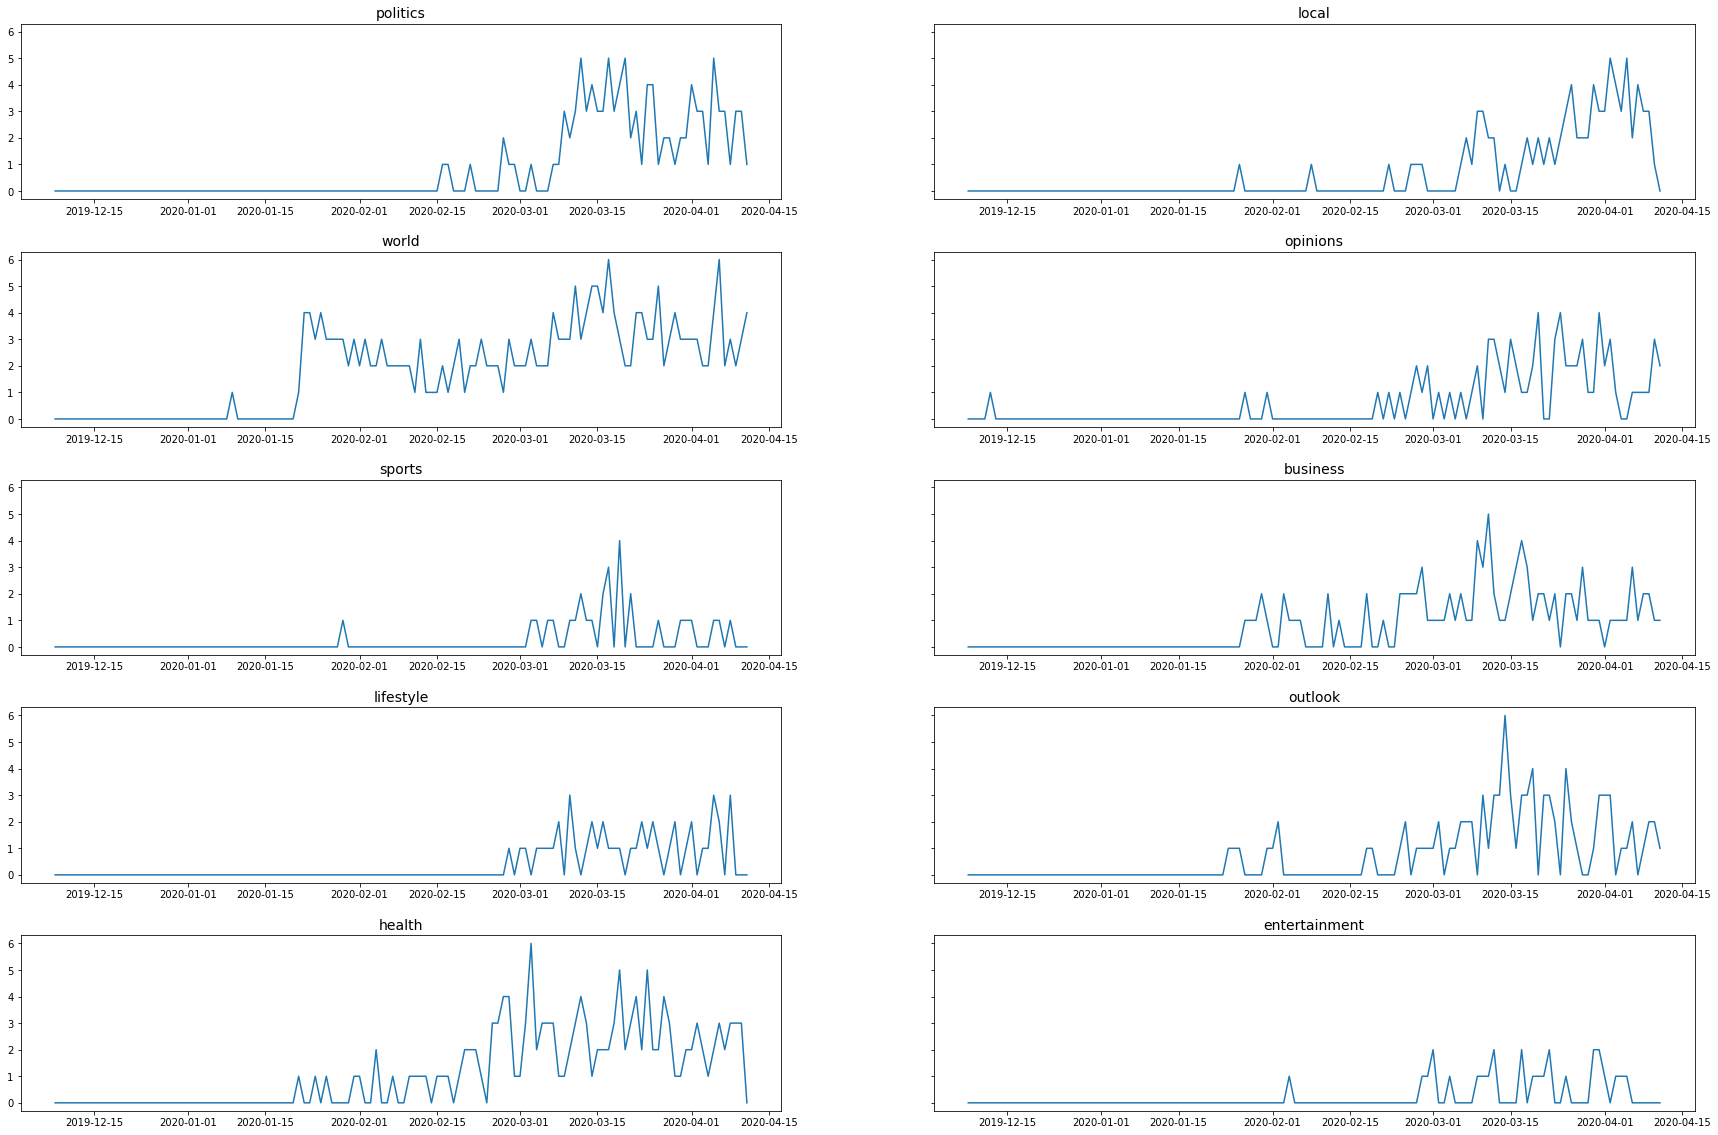

In [917]:
fig, axarr = plt.subplots(5, 2, figsize=(30, 20), sharey=True)
fig.subplots_adjust(hspace=.3)

axarr[0, 0].plot(date_range, section_appearances['politics'])
axarr[0, 0].set_title('politics', fontsize=14)

axarr[0, 1].plot(date_range, section_appearances['local'])
axarr[0, 1].set_title('local', fontsize=14)

axarr[1, 0].plot(date_range, section_appearances['world'])
axarr[1, 0].set_title('world', fontsize=14)

axarr[1, 1].plot(date_range, section_appearances['opinions'])
axarr[1, 1].set_title('opinions', fontsize=14)

axarr[2, 0].plot(date_range, section_appearances['sports'])
axarr[2, 0].set_title('sports', fontsize=14)

axarr[2, 1].plot(date_range, section_appearances['business'])
axarr[2, 1].set_title('business', fontsize=14)

axarr[3, 0].plot(date_range, section_appearances['lifestyle'])
axarr[3, 0].set_title('lifestyle', fontsize=14)

axarr[3, 1].plot(date_range, section_appearances['outlook'])
axarr[3, 1].set_title('outlook', fontsize=14)

axarr[4, 0].plot(date_range, section_appearances['health'])
axarr[4, 0].set_title('health', fontsize=14)

axarr[4, 1].plot(date_range, section_appearances['entertainment'])
axarr[4, 1].set_title('entertainment', fontsize=14)

plt.show()

What day did each section first mention coronavirus on the front page?

In [926]:
for section in section_appearances:
    first_day = next((i for i, x in enumerate(section_appearances[section]) if x), None)
    print(section + ': ' + str(date_range[first_day]))
    
    # What article was that?
    # Need to fix both headlines and sections code together. 

politics: 2020-02-16 00:00:00
local: 2020-01-26 00:00:00
world: 2020-01-09 00:00:00
opinions: 2019-12-12 00:00:00
sports: 2020-01-29 00:00:00
business: 2020-01-27 00:00:00
lifestyle: 2020-02-28 00:00:00
outlook: 2020-01-24 00:00:00
health: 2020-01-21 00:00:00
entertainment: 2020-02-04 00:00:00


Which sections mention coronavirus the most? (Make bar graph).

In [930]:
for section in section_appearances:
    total = section_appearances[section].sum()
    print(section + ': ' + str(int(total)))

politics: 107
local: 86
world: 228
opinions: 77
sports: 29
business: 100
lifestyle: 46
outlook: 91
health: 143
entertainment: 27


## Sentiment analysis

## word2vec

**Load pre-trained word2vec model**

Since this is a news dataset, we use the Google News model, which was trained on about 100 billion words. Download it here. https://code.google.com/archive/p/word2vec/

Other models: https://github.com/RaRe-Technologies/gensim-data

In [385]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True)

Check dimension of word vectors

In [386]:
model.vector_size

300

word2vec can't create a vector from a word that's not in its vocabulary. Because of this, we need to specify "if word in model.vocab" when creating the full list of word vectors.

In [9]:
model['coronavirus']

NameError: name 'model' is not defined

In [439]:
vector_list = [model[word] for word in words if word in model.vocab]
len(vector_list)

33252

Create a list of the words corresponding to these vectors

In [440]:
words_filtered = [word for word in words if word in model.vocab]
len(words_filtered)

33252

Zip the words together with their vector representations

In [441]:
word_vec_zip = zip(words_filtered, vector_list)
word_vec_zip

Cast to dict so we can turn it into a DataFrame

In [442]:
word_vec_dict = dict(word_vec_zip)
df_words = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_words.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
House,0.065430,0.058838,-0.328125,0.035156,-0.214844,-0.079102,0.141602,0.300781,0.096191,0.088867,...,-0.300781,-0.148438,-0.063477,0.065918,-0.180664,-0.077637,-0.140625,-0.130859,0.187500,0.241211
legal,-0.237305,0.124023,-0.184570,-0.027710,0.063965,0.118164,0.178711,0.173828,0.146484,0.102539,...,0.216797,-0.034912,-0.073242,-0.054443,-0.062988,0.277344,0.111816,-0.061279,-0.054199,0.205078
team,-0.253906,0.028564,0.104492,-0.075684,0.104980,-0.024170,-0.107910,-0.216797,0.093262,0.030640,...,-0.036865,0.138672,-0.163086,-0.168945,-0.031128,0.137695,0.013000,-0.081543,-0.092773,-0.068848
spar,-0.172852,0.388672,-0.098145,-0.100586,-0.148438,0.210938,0.012756,0.037109,0.092285,0.375000,...,0.339844,-0.417969,0.129883,0.255859,-0.494141,-0.343750,-0.226562,-0.110352,-0.271484,0.125977
over,0.088867,0.095703,0.014771,0.060791,-0.037598,-0.207031,0.004913,-0.324219,0.145508,0.275391,...,-0.020508,0.109375,-0.086426,0.028931,-0.137695,-0.064941,-0.053955,-0.006378,-0.193359,-0.100586
rules,-0.069824,0.133789,0.238281,0.021362,-0.194336,-0.259766,-0.074219,0.032959,-0.241211,-0.115234,...,-0.034912,-0.041992,0.082031,-0.310547,0.073242,-0.038086,0.219727,-0.127930,-0.031738,-0.055176
guide,0.038330,-0.022949,-0.138672,-0.263672,0.002792,-0.018677,-0.088867,-0.072754,-0.027466,-0.335938,...,0.022827,-0.072266,0.096191,-0.119629,-0.014343,-0.053223,-0.084473,-0.050049,0.171875,0.153320
trial,-0.091797,0.186523,-0.031738,0.154297,0.213867,0.016602,0.226562,-0.072266,0.120605,0.328125,...,0.086914,-0.053223,0.021973,-0.068359,0.087402,0.095215,-0.089355,-0.175781,0.018433,0.211914
Senate,0.006744,-0.021240,-0.277344,0.133789,-0.265625,-0.347656,0.025391,0.410156,0.184570,0.101074,...,-0.404297,-0.229492,0.106445,-0.195312,-0.079590,0.122559,-0.225586,-0.133789,0.267578,0.378906
rejects,0.009827,0.226562,0.281250,-0.361328,-0.060791,0.058838,0.102051,-0.035400,0.147461,0.128906,...,-0.075195,-0.185547,-0.283203,0.318359,-0.361328,0.251953,0.078613,0.030640,-0.103516,0.203125


Find titles that cluster together.

Instead of using doc2vec, which does not have pre-trained models available and so would require a lengthy training proocess, we can use a simpler (and sometimes even more effective) trick: averaging the embeddings of the word vectors in each document. In our case, a document refers to a title. https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [444]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)

Preprocess the corpus.

In [453]:
corpus = [preprocess(title) for title in all_headlines]

Remove docs that don't include any words in W2V's vocab

In [455]:
corpus, titles_list = filter_docs(corpus, 
                                  all_headlines, 
                                  lambda doc: has_vector_representation(model, doc))

153 docs removed


Filter out any empty docs

In [456]:
corpus, titles_list = filter_docs(corpus, 
                                  all_headlines, 
                                  lambda doc: (len(doc) != 0))

0 docs removed


In [457]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x) # list to array

In [458]:
X

array([[-0.09486219,  0.10024685, -0.01056586, ..., -0.11677381,
        -0.03533936,  0.08824328],
       [-0.01110162,  0.0616862 ,  0.03975995, ..., -0.06128608,
        -0.02565002,  0.06477865],
       [-0.06600952,  0.05895996,  0.06152344, ..., -0.0677948 ,
         0.02059937,  0.0579834 ],
       ...,
       [-0.08825684,  0.09500122,  0.03942871, ..., -0.05781555,
         0.12561035,  0.01688385],
       [-0.0949707 , -0.04296875,  0.08349609, ..., -0.0300293 ,
         0.03051758, -0.14111328],
       [-0.04170736,  0.11686198,  0.02229818, ...,  0.03027344,
         0.00777181, -0.08314768]], dtype=float32)

In [571]:
model.most_similar(positive=['coronavirus'])

[('corona_virus', 0.7276226878166199),
 ('coronaviruses', 0.7216537594795227),
 ('paramyxovirus', 0.7113004326820374),
 ('SARS_coronavirus', 0.6601907014846802),
 ('arenavirus', 0.6494410037994385),
 ('influenza_virus', 0.644982635974884),
 ('H#N#_subtype', 0.6360139846801758),
 ('H#N#_strain', 0.6324742436408997),
 ('H7_virus', 0.6261192560195923),
 ('flu_virus', 0.6249204874038696)]

In [572]:
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100, verbose=1)
tsne_df = tsne.fit_transform(X)

Color the headlines that explicitly mention coronavirus, COVID-19, or SARS-COV-2.

In [647]:
colors = []

for headline in titles_list:
    if 'coronavirus' in headline.lower() or 'covid-19' in headline.lower() or 'covid19' in headline.lower(): 
        colors.append(1)
    else:
        colors.append(0)
        
pd.Series(colors).value_counts()

3922

Find which row/date the headline belongs to

In [782]:
headlines = list(df['headlines'].apply(literal_eval))
index = list(df['date'])
series = pd.Series(headlines, index=index)
weeks = series.resample('7D').sum().apply(lambda x: list(x))
weeks

2020-01-21    [House managers, Trump’s legal team spar over ...
2020-01-28    [Trump defense team finishes opening arguments...
2020-02-04    [Sanders, Buttigieg leading in early results, ...
2020-02-11    [Listen to Post Reports, How the CIA tricked a...
2020-02-18    [Listen to Post Reports, Allegations of Mike B...
2020-02-25    [Dow dives 900 points after CDC warns of coron...
2020-03-03    [Biden’s surge continues as Bloomberg ends bid...
2020-03-10    [N.Y. governor orders containment zone in New ...
2020-03-17    [Virus now in all 50 states, D.C., after W.Va....
2020-03-24    [Trump wants ‘country opened’ by Easter, White...
2020-03-31    [Officials project 100,000 to 240,000 U.S. dea...
2020-04-07    [Trump removes inspector general who was to ov...
Freq: 7D, dtype: object

In [794]:
len(weeks)

12

2020-01-21    [House managers, Trump’s legal team spar over ...
2020-01-28    [Trump defense team finishes opening arguments...
2020-02-04    [Sanders, Buttigieg leading in early results, ...
2020-02-11    [Listen to Post Reports, How the CIA tricked a...
2020-02-18    [Listen to Post Reports, Allegations of Mike B...
2020-02-25    [Dow dives 900 points after CDC warns of coron...
2020-03-03    [Biden’s surge continues as Bloomberg ends bid...
2020-03-10    [N.Y. governor orders containment zone in New ...
2020-03-17    [Virus now in all 50 states, D.C., after W.Va....
2020-03-24    [Trump wants ‘country opened’ by Easter, White...
2020-03-31    [Officials project 100,000 to 240,000 U.S. dea...
2020-04-07    [Trump removes inspector general who was to ov...
Freq: 7D, dtype: object

In [800]:
# For each title in title_list, find which row/date it belongs to in df
# And assign it the index number, we will color this 
colors_by_weeks = []

for title in titles_list:
    for i, week in enumerate(weeks): 
        if title in week: 
            colors_by_weeks.append(i)
            break
            
len(colors_by_weeks)

3922

In [812]:
pd.Series(colors_by_weeks).value_counts()

0     613
6     409
4     402
8     391
2     376
7     344
9     333
3     316
1     302
5     258
10    178
dtype: int64

Plot, colored by whether the title contains the words 'coronavirus' or 'COVID19'

<IPython.core.display.Javascript object>


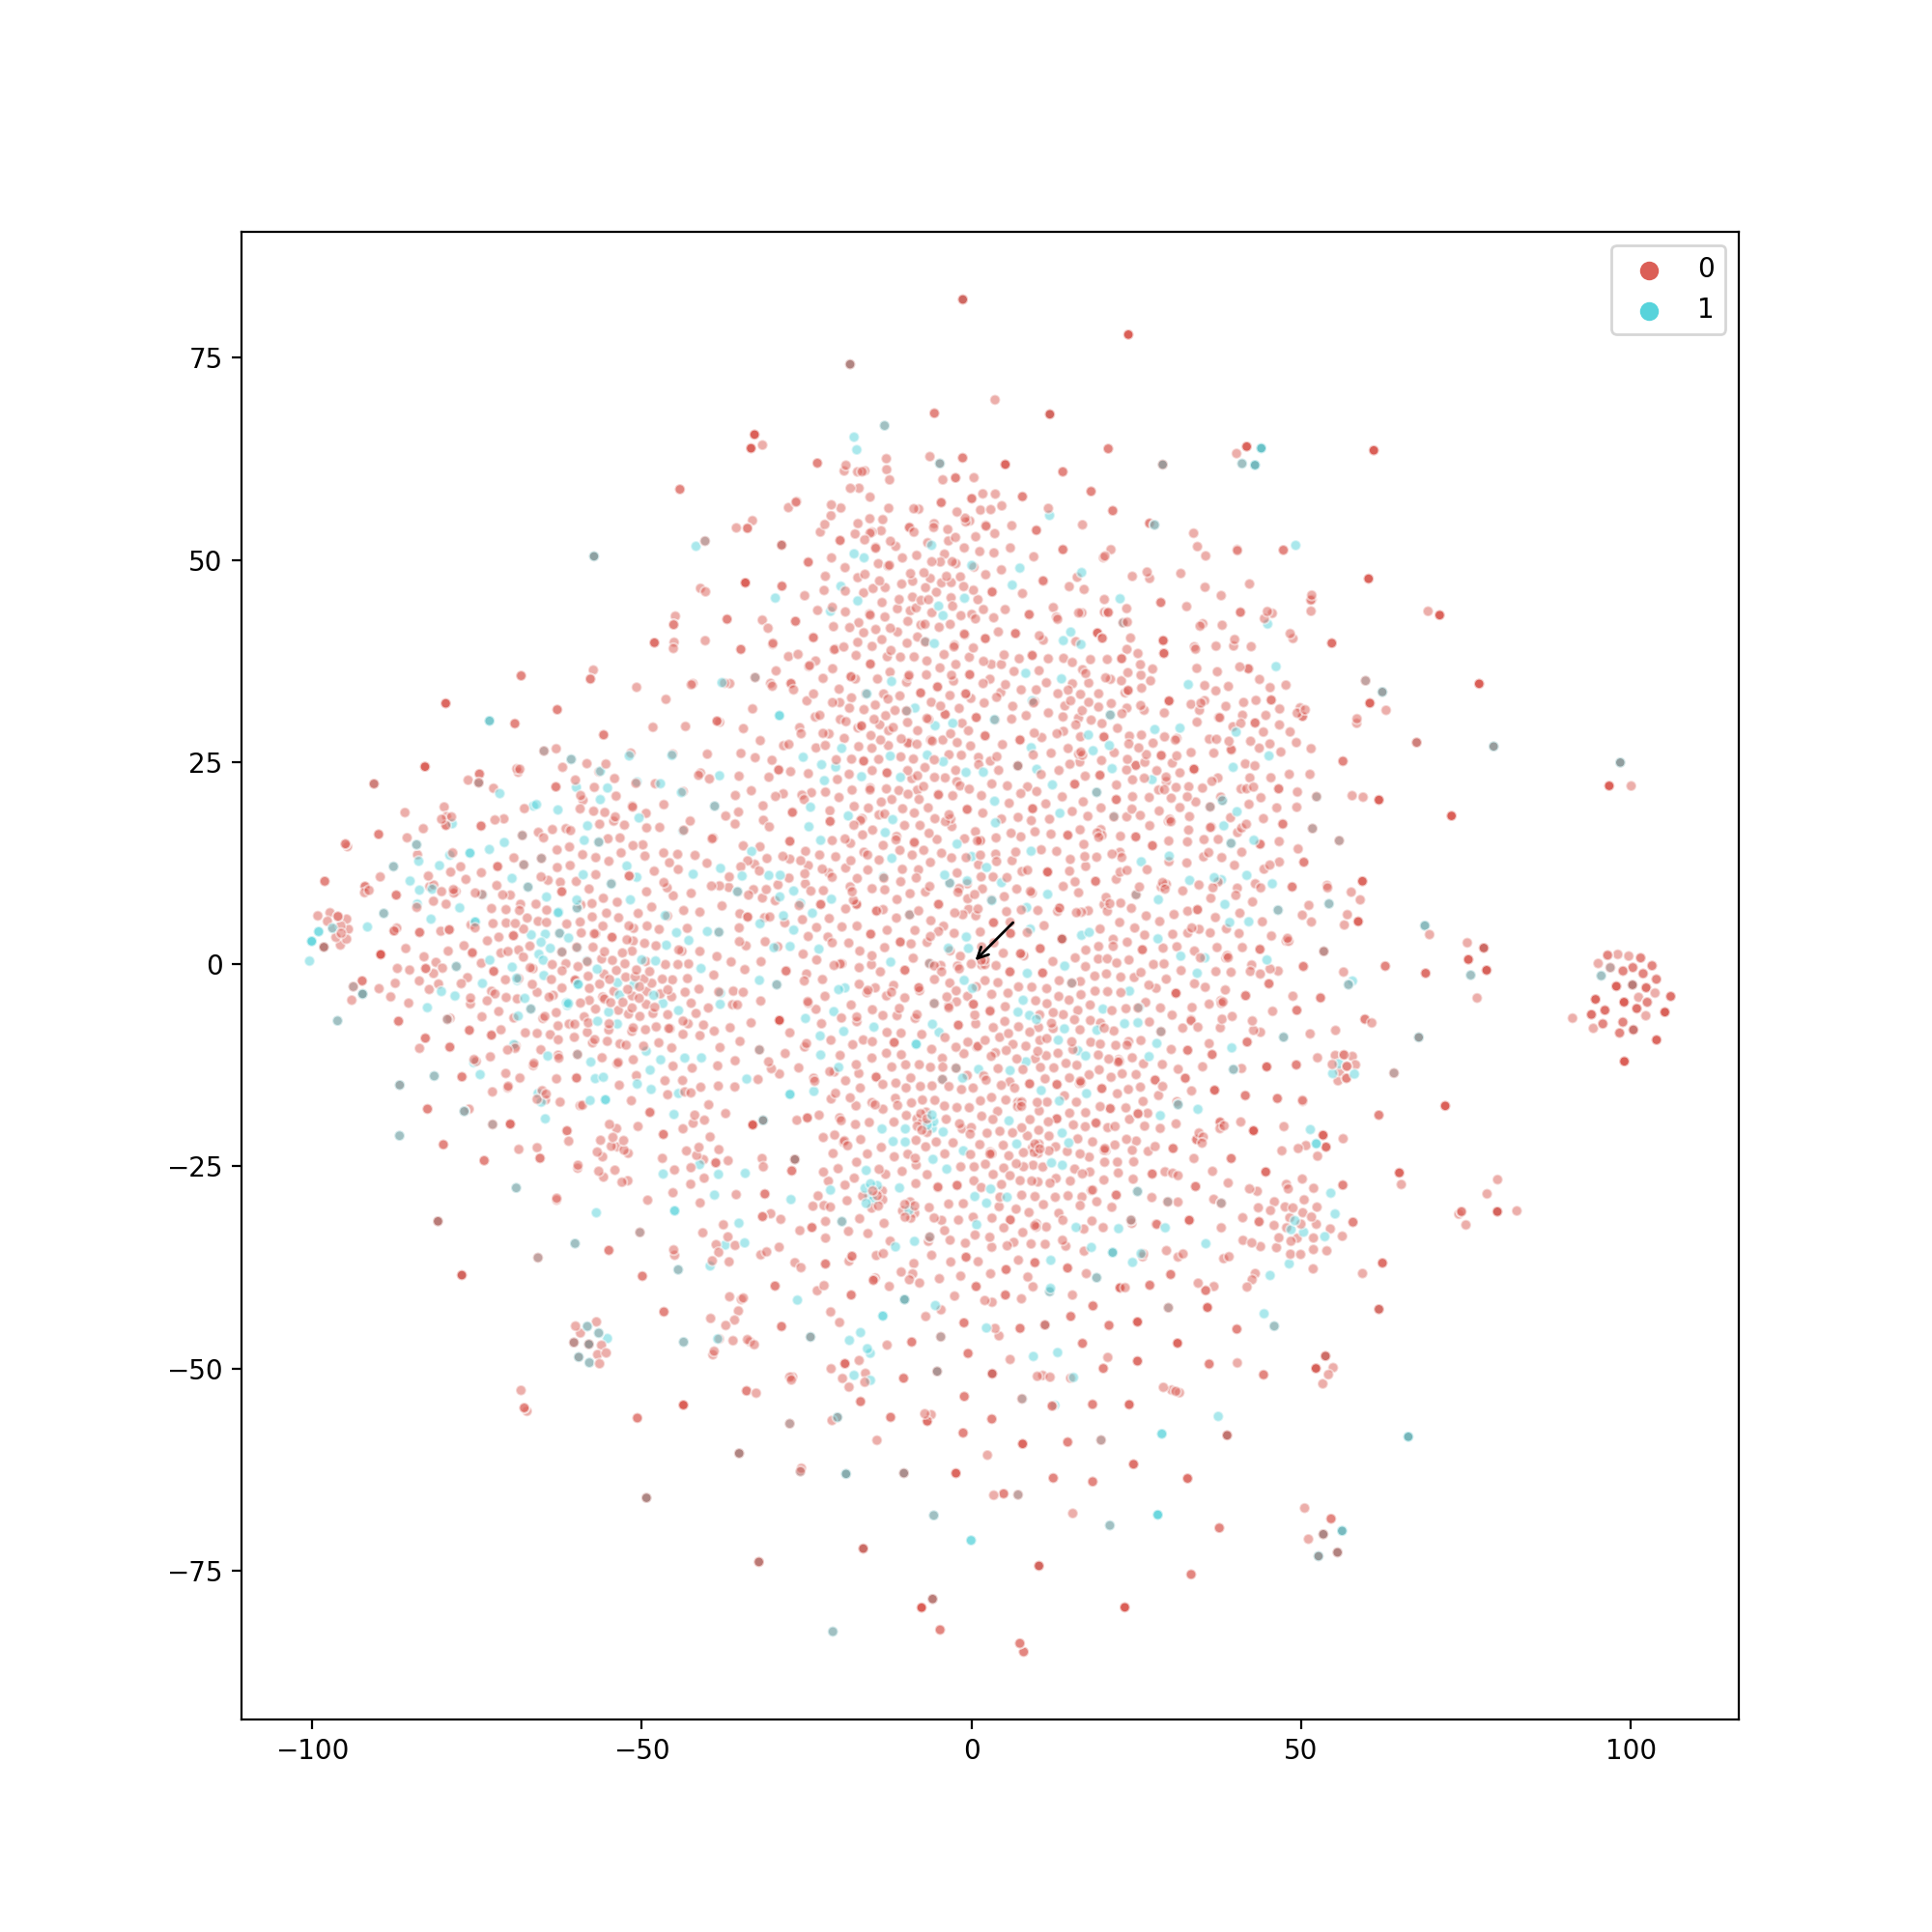

In [816]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], tsne_df[:,1], alpha=0.5, s=15, hue=colors, 
                      palette=sns.color_palette('hls', 2))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(True)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

Plot, colored by week

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

scp = sns.scatterplot(tsne_df[:,0], 
                      tsne_df[:,1], 
                      alpha=0.5, 
                      s=15, 
                      hue=colors_by_weeks,
                      palette=sns.color_palette('hls', 11))

annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords='offset points',
                    bbox=dict(boxstyle='round', fc='w'),
                    arrowprops=dict(arrowstyle='->'))
annot.set_visible(False)

def update_annot(ind):
    pos = scp.get_offsets()[ind['ind'][0]]
    annot.xy = pos
    text = '{}'.format(all_headlines[ind['ind'][0]])
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor('white')
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scp.contains(event)
        if cont: 
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
                
fig.canvas.mpl_connect('motion_notify_event', hover)

plt.show()

In [620]:
all_headlines[277]

'Alta and Snowbird are renowned ski destinations but crowded. Instead, try Solitude.'

In [622]:
all_headlines[325]

'It’s time for radical change at the Grammys — and the clock is ticking'

## Doc2vec

Can I plot it with the rest of Google News document vectors?

In [508]:
len(all_headlines)

4075

In [ ]:
words = ' '.join(all_headlines).split(' ')
words

In [ ]:
stop_words = set(stopwords.words('english'))
len(stop_words)

Tokenize each headline, removing stopwords. 

In [510]:
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i,_d in enumerate(all_headlines) if _d not in stop_words]

In [511]:
len(train_corpus)

4075

Train model.

In [542]:
model_doc2vec = Doc2Vec(vector_size=300,
                        alpha=0.025,
                        min_alpha = 0.001,
                        min_count=1,
                        workers=10, 
                        dm=1,
                        epochs=40)

model_doc2vec.build_vocab(train_corpus)

Train model for 10 epochs.

In [543]:
start = timer()
model_doc2vec.train(train_corpus, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)
model_doc2vec.save('d2v.model')
print('Model Saved')
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Model Saved
Execution time HH:MM:SS: 0:00:23.755177


In [537]:
model_doc2vec[0]

array([ 1.3504637e-02,  8.2566766e-03, -2.1916255e-03,  4.3237326e-03,
       -9.4604604e-03,  1.5311696e-03, -1.2774942e-02, -6.5150219e-03,
       -1.2243640e-03, -1.4054816e-02, -1.3206872e-02, -6.5680663e-03,
        3.9786624e-04,  1.6083424e-03, -3.1921580e-03, -2.8327331e-03,
        2.4701109e-02, -6.5988651e-03,  2.4777565e-02,  1.7686073e-02,
        1.4777459e-02,  2.6327069e-04, -3.0054459e-02, -1.0576738e-02,
        1.0586901e-02,  1.7423746e-03, -5.0879340e-03, -5.7256166e-03,
        1.5045743e-02, -5.4006162e-03, -1.2176604e-02, -1.1682622e-02,
        9.5394859e-03, -1.9388972e-02, -3.3118133e-03, -6.8102687e-05,
        3.7937851e-03,  1.7227162e-02, -3.1893281e-03, -1.3738032e-03,
       -3.0077607e-04, -1.0218359e-02,  1.2085522e-02, -3.3307194e-03,
        1.2321858e-02, -4.2730637e-04,  5.6988602e-03, -3.3569229e-03,
       -1.1657155e-02,  9.3366858e-03,  3.0945492e-04,  2.5784165e-02,
       -1.6956830e-02,  2.9948445e-03, -1.1000807e-02, -6.3609325e-05,
      

Get the documents from the model.

In [515]:
doc_tags = list(model_doc2vec.docvecs.doctags.keys())
docs = model_doc2vec[doc_tags]
len(docs)

4075

In [516]:
docs[0]

array([ 0.07174653,  0.05016864,  0.03845977,  0.02634695, -0.07409763,
        0.02918518, -0.06415798, -0.05565873, -0.0027413 , -0.09055971],
      dtype=float32)

In [517]:
model_doc2vec.docvecs.most_similar(0)

[('3328', 0.9699888825416565),
 ('2767', 0.9683275818824768),
 ('504', 0.9664832353591919),
 ('2206', 0.9641293883323669),
 ('1856', 0.9629613161087036),
 ('2775', 0.9622619152069092),
 ('2449', 0.9612644910812378),
 ('1338', 0.96107417345047),
 ('602', 0.9608083367347717),
 ('267', 0.9546763300895691)]

In [518]:
all_headlines[0]

'House managers, Trump’s legal team spar over rules to guide trial'

In [519]:
all_headlines[3328]

'Chat Transcript: Ways to maintain your mental health during the coronavirus outbreak'

In [10]:
all_headlines[504]

'A guide to local favorites on Freret Street'

In [557]:
model_doc2vec.wv.most_similar('italy')

[('china', 0.9221874475479126),
 ('death', 0.9145364761352539),
 ('toll', 0.9133531451225281),
 ('deaths', 0.9032647609710693),
 (';', 0.9004700779914856),
 ('confirmed', 0.8946788907051086),
 ('cases', 0.8926124572753906),
 ('spike', 0.8825417757034302),
 ('spreads', 0.8822505474090576),
 ('plunge', 0.8802657723426819)]

**Sentiment analysis**

In [30]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [31]:
sia = SIA()

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
results = []

for line in title_list:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)
    
pprint(results[:3], width=100)